<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, backtest_plot_mod, get_daily_return, get_baseline
from pprint import pprint

import sys
#sys.path.append("../FinRL-Library")

import itertools
import os

import pickle

/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
%matplotlib inline

<a id='2'></a>
# Part 3. Get Data


In [3]:
input_data_path = '../data'
input_data_filename = 'binance_BTCUSDT_1h_from_2020_01_01_to_2021_12_31_candlesticks_signals_processed_technical_indicators_and_crypto_index_v2'
input_data_extension = ".csv"
full_path_input_data = os.path.join(input_data_path, input_data_filename + input_data_extension)

In [4]:
df = pd.read_csv(full_path_input_data)

In [5]:
df.shape

(17369, 92)

In [6]:
df.head()

,time,open_time,open,high,low,close,volume,close_time,quote_asset_volumne,number_of_trades,...,AD,ATR,HT_DC,SAR,ratio_high_open,ratio_low_open,ratio_close_open,time_to_chart_return,crypto_index,datetime
0,2020-01-06 02:00:00,1578272400000,7378.97,7426.82,7368.55,7423.50,1630.227541,1578275999999,1.204807e+07,14099,...,21356.874781,43.363627,17.869168,7457.127929,1.006485,0.998588,1.006035,0.006065,1006.064713,2020-01-06 02:00:00
1,2020-01-06 03:00:00,1578276000000,7423.06,7562.00,7421.64,7551.44,5819.256972,1578279599999,4.366371e+07,38256,...,26300.506879,50.291939,17.479081,7318.000000,1.018717,0.999809,1.017295,0.017234,1023.403693,2020-01-06 03:00:00
2,2020-01-06 04:00:00,1578279600000,7551.47,7580.00,7486.85,7540.90,4769.906356,1578283199999,3.593969e+07,27817,...,27066.047406,53.353229,17.115744,7322.880000,1.003778,0.991443,0.998600,-0.001396,1021.975267,2020-01-06 04:00:00
3,2020-01-06 05:00:00,1578283200000,7540.90,7554.61,7516.06,7529.52,1554.582461,1578286799999,1.171094e+07,13475,...,26597.051452,52.295856,16.755815,7333.164800,1.001818,0.996706,0.998491,-0.001509,1020.433000,2020-01-06 05:00:00
4,2020-01-06 06:00:00,1578286800000,7529.52,7541.55,7496.00,7532.85,1472.919930,1578290399999,1.107363e+07,12768,...,27507.319202,51.814009,16.304649,7343.038208,1.001598,0.995548,1.000442,0.000442,1020.884296,2020-01-06 06:00:00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17369 entries, 0 to 17368
Data columns (total 92 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   time                          17369 non-null  object 
 1   open_time                     17369 non-null  int64  
 2   open                          17369 non-null  float64
 3   high                          17369 non-null  float64
 4   low                           17369 non-null  float64
 5   close                         17369 non-null  float64
 6   volume                        17369 non-null  float64
 7   close_time                    17369 non-null  int64  
 8   quote_asset_volumne           17369 non-null  float64
 9   number_of_trades              17369 non-null  int64  
 10  taker_buy_base_asset_volume   17369 non-null  float64
 11  taker_buy_quote_asset_volume  17369 non-null  float64
 12  ignore                        17369 non-null  int64  
 13  f

In [8]:
df.columns

Index(['time', 'open_time', 'open', 'high', 'low', 'close', 'volume',
       'close_time', 'quote_asset_volumne', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore',
       'formatted_open_time', 'formatted_close_time', 'upper_shadow',
       'lower_shadow', 'real_body', 'CDLINVERTEDHAMMER', 'CDLHAMMER',
       'CDLPIERCING', 'CDLMORNINGSTAR', 'CDLSHOOTINGSTAR', 'CDLHANGINGMAN',
       'CDLDARKCLOUDCOVER', 'CDLEVENINGSTAR', 'CDLENGULFING',
       'CDLENGULFINGBULLISH', 'CDLENGULFINGBEARISH', 'CDLINVERTEDHAMMER_NEW',
       'CDLHAMMER_NEW', 'CDLPIERCING_NEW', 'CDLMORNINGSTAR_NEW',
       'CDLENGULFINGBULLISH_NEW', 'CDLSHOOTINGSTAR_NEW', 'CDLHANGINGMAN_NEW',
       'CDLDARKCLOUDCOVER_NEW', 'CDLEVENINGSTAR_NEW',
       'CDLENGULFINGBEARISH_NEW', 'MA5', 'MA10', 'MA20', 'MA60', 'MA120',
       'volume_MA5', 'volume_MA10', 'volume_MA20', 'SMA5', 'SMA10', 'SMA20',
       'SMA60', 'SMA120', 'volume_SMA5', 'volume_SMA10', 'volume_SMA20',
       'W

In [9]:
df.rename(columns = {'time':'date'}, inplace = True)
# df.rename(columns = {'formatted_open_time':'date'}, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17369 entries, 0 to 17368
Data columns (total 92 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          17369 non-null  object 
 1   open_time                     17369 non-null  int64  
 2   open                          17369 non-null  float64
 3   high                          17369 non-null  float64
 4   low                           17369 non-null  float64
 5   close                         17369 non-null  float64
 6   volume                        17369 non-null  float64
 7   close_time                    17369 non-null  int64  
 8   quote_asset_volumne           17369 non-null  float64
 9   number_of_trades              17369 non-null  int64  
 10  taker_buy_base_asset_volume   17369 non-null  float64
 11  taker_buy_quote_asset_volume  17369 non-null  float64
 12  ignore                        17369 non-null  int64  
 13  f

In [11]:
df["tic"] = 'BTCUSDT'

In [12]:
#df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d").dt.date

In [13]:
df_col_selected = df[['date', 'tic', 'open', 'high', 'low', 'close', 'volume',
        'upper_shadow', 'lower_shadow', 'real_body',
        'MACD_12_26_9', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'RSI_14', 'CCI_14', 'WMA20', 'WMA60',
        'CDLINVERTEDHAMMER_NEW', 'CDLHAMMER_NEW', 'CDLMORNINGSTAR_NEW', 'CDLENGULFINGBULLISH_NEW', 
        'CDLSHOOTINGSTAR_NEW', 'CDLHANGINGMAN_NEW', 'CDLEVENINGSTAR_NEW', 'CDLENGULFINGBEARISH_NEW']]

In [14]:
df_col_selected.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2020-01-06 02:00:00,BTCUSDT,7378.97,7426.82,7368.55,7423.50,1630.227541,3.32,10.42,44.53,...,7415.848000,7397.087956,0,0,0,0,0,0,0,0
1,2020-01-06 03:00:00,BTCUSDT,7423.06,7562.00,7421.64,7551.44,5819.256972,10.56,1.42,128.38,...,7427.744619,7402.918470,0,0,0,0,0,0,0,0
2,2020-01-06 04:00:00,BTCUSDT,7551.47,7580.00,7486.85,7540.90,4769.906356,28.53,54.05,10.57,...,7438.190095,7408.241273,0,0,0,0,0,0,0,0
3,2020-01-06 05:00:00,BTCUSDT,7540.90,7554.61,7516.06,7529.52,1554.582461,13.71,13.46,11.38,...,7447.183810,7413.070350,0,0,0,0,0,0,0,0
4,2020-01-06 06:00:00,BTCUSDT,7529.52,7541.55,7496.00,7532.85,1472.919930,8.70,33.52,3.33,...,7456.021000,7417.930197,0,0,0,0,0,0,0,0


In [15]:
df_col_selected.tail()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
17364,2021-12-30 21:00:00,BTCUSDT,47558.35,47682.07,47071.00,47203.16,1456.46283,123.72,132.16,355.19,...,47304.526429,47337.674639,0,0,0,0,0,0,0,0
17365,2021-12-30 22:00:00,BTCUSDT,47203.16,47347.84,46919.44,47300.00,890.70108,47.84,283.72,96.84,...,47322.098714,47327.219197,0,0,0,0,0,0,0,0
17366,2021-12-30 23:00:00,BTCUSDT,47299.99,47325.33,46729.00,47084.88,792.93614,25.34,355.88,215.11,...,47315.672429,47310.654596,0,0,0,0,0,0,0,0
17367,2021-12-31 00:00:00,BTCUSDT,47084.88,47242.60,46940.96,47120.87,710.18694,121.73,143.92,35.99,...,47310.659810,47296.335399,0,0,0,0,0,0,0,0
17368,2021-12-31 01:00:00,BTCUSDT,47120.88,47500.00,46826.21,47073.98,1084.11426,379.12,247.77,46.90,...,47298.244000,47281.615175,0,0,0,0,0,0,0,0


In [16]:
#df_col_selected.plot(x='date', y='close')
df_col_selected.isna().any().any()

False

### Check missing date

In [17]:
df_check_date = df_col_selected[['date']]

In [18]:
# Setting the Date values as index
df_check_date = df_check_date.set_index('date')
 
# to_datetime() method converts string
# format to a DateTime object
df_check_date.index = pd.to_datetime(df_check_date.index)
 
# dates which are not in the sequence
# are returned
print(pd.date_range(
  start="2017-12-15", end="2021-12-31").difference(df_check_date.index))

DatetimeIndex(['2017-12-15', '2017-12-16', '2017-12-17', '2017-12-18',
               '2017-12-19', '2017-12-20', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24',
               ...
               '2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31',
               '2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06'],
              dtype='datetime64[ns]', length=753, freq=None)


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [19]:
fe = FeatureEngineer(
                    use_technical_indicator=False,
                    #tech_indicator_list = ["macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30", "close_30_sma", "close_60_sma"],
                    use_vix=False,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df_col_selected)

In [20]:
processed.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2020-01-06 02:00:00,BTCUSDT,7378.97,7426.82,7368.55,7423.50,1630.227541,3.32,10.42,44.53,...,7415.848000,7397.087956,0,0,0,0,0,0,0,0
1,2020-01-06 03:00:00,BTCUSDT,7423.06,7562.00,7421.64,7551.44,5819.256972,10.56,1.42,128.38,...,7427.744619,7402.918470,0,0,0,0,0,0,0,0
2,2020-01-06 04:00:00,BTCUSDT,7551.47,7580.00,7486.85,7540.90,4769.906356,28.53,54.05,10.57,...,7438.190095,7408.241273,0,0,0,0,0,0,0,0
3,2020-01-06 05:00:00,BTCUSDT,7540.90,7554.61,7516.06,7529.52,1554.582461,13.71,13.46,11.38,...,7447.183810,7413.070350,0,0,0,0,0,0,0,0
4,2020-01-06 06:00:00,BTCUSDT,7529.52,7541.55,7496.00,7532.85,1472.919930,8.70,33.52,3.33,...,7456.021000,7417.930197,0,0,0,0,0,0,0,0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [21]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17369 entries, 0 to 17366
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     17369 non-null  object 
 1   tic                      17369 non-null  object 
 2   open                     17369 non-null  float64
 3   high                     17369 non-null  float64
 4   low                      17369 non-null  float64
 5   close                    17369 non-null  float64
 6   volume                   17369 non-null  float64
 7   upper_shadow             17369 non-null  float64
 8   lower_shadow             17369 non-null  float64
 9   real_body                17369 non-null  float64
 10  MACD_12_26_9             17369 non-null  float64
 11  BBANDS_U                 17369 non-null  float64
 12  BBANDS_M                 17369 non-null  float64
 13  BBANDS_L                 17369 non-null  float64
 14  RSI_14                

## Training data split:
## Trade data split:

In [22]:
train = data_split(processed, '2020-01-01','2021-06-30')
trade = data_split(processed, '2021-06-30','2021-12-30')
print(len(train))
print(len(trade))

12956
4387


In [23]:
train.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2020-01-06 02:00:00,BTCUSDT,7378.97,7426.82,7368.55,7423.50,1630.227541,3.32,10.42,44.53,...,7415.848000,7397.087956,0,0,0,0,0,0,0,0
1,2020-01-06 03:00:00,BTCUSDT,7423.06,7562.00,7421.64,7551.44,5819.256972,10.56,1.42,128.38,...,7427.744619,7402.918470,0,0,0,0,0,0,0,0
2,2020-01-06 04:00:00,BTCUSDT,7551.47,7580.00,7486.85,7540.90,4769.906356,28.53,54.05,10.57,...,7438.190095,7408.241273,0,0,0,0,0,0,0,0
3,2020-01-06 05:00:00,BTCUSDT,7540.90,7554.61,7516.06,7529.52,1554.582461,13.71,13.46,11.38,...,7447.183810,7413.070350,0,0,0,0,0,0,0,0
4,2020-01-06 06:00:00,BTCUSDT,7529.52,7541.55,7496.00,7532.85,1472.919930,8.70,33.52,3.33,...,7456.021000,7417.930197,0,0,0,0,0,0,0,0


In [24]:
train.tail()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
12950,2021-06-29 19:00:00,BTCUSDT,36341.89,36600.00,36140.00,36370.20,4479.207971,229.80,201.89,28.31,...,35656.473095,34856.459552,0,0,0,0,0,0,0,0
12951,2021-06-29 20:00:00,BTCUSDT,36370.20,36395.00,36116.77,36280.85,2415.142625,24.80,164.08,89.35,...,35750.393762,34919.649497,0,0,0,0,0,0,0,0
12952,2021-06-29 21:00:00,BTCUSDT,36280.85,36399.99,36205.01,36382.39,1488.351831,17.60,75.84,101.54,...,35845.133238,34984.419645,0,0,0,0,0,0,0,0
12953,2021-06-29 22:00:00,BTCUSDT,36382.39,36488.70,36099.79,36156.04,3020.202163,106.31,56.25,226.35,...,35909.327476,35040.074918,0,0,0,0,0,0,0,0
12954,2021-06-29 23:00:00,BTCUSDT,36156.03,36323.76,36106.46,36240.01,1982.910900,83.75,49.57,83.98,...,35975.550381,35096.769590,0,0,0,0,0,0,0,0


In [42]:
trade[trade.duplicated(['date'])]

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
2948,2021-10-31 02:00:00,BTCUSDT,62375.28,62405.3,62114.18,62169.0,1695.15085,30.02,54.82,206.28,...,61678.827714,61653.699787,0,0,0,0,0,0,0,0


In [45]:
trade = trade.drop_duplicates('date')

In [46]:
trade.iloc[2945:2955]

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
2945,2021-10-30 23:00:00,BTCUSDT,61642.10,61699.80,61426.04,61429.03,912.48687,57.70,2.99,213.07,...,61512.190905,61588.176213,0,0,0,0,0,0,0,0
2946,2021-10-31 00:00:00,BTCUSDT,61429.02,61624.00,61175.01,61540.33,1810.10864,83.67,254.01,111.31,...,61511.712095,61590.577776,0,0,0,0,0,0,0,0
2947,2021-10-31 01:00:00,BTCUSDT,61540.32,61900.00,61479.76,61859.19,1749.61796,40.81,60.56,318.87,...,61543.184857,61603.152612,0,0,0,0,0,0,0,0
2948,2021-10-31 02:00:00,BTCUSDT,61859.19,62400.15,61859.18,62375.29,2649.54855,24.86,0.01,516.10,...,61622.956476,61632.157732,0,0,0,0,0,0,0,0
2949,2021-10-31 03:00:00,BTCUSDT,62169.00,62290.00,61620.00,61741.01,1686.69741,121.00,121.01,427.99,...,61690.994333,61660.893437,0,0,0,0,0,0,0,0
2950,2021-10-31 04:00:00,BTCUSDT,61741.00,61883.01,61581.96,61697.84,1204.90001,142.01,115.88,43.16,...,61699.234286,61666.563005,0,0,0,0,0,0,0,0
2951,2021-10-31 05:00:00,BTCUSDT,61697.85,61746.28,61400.24,61404.85,1437.43341,48.43,4.61,293.00,...,61679.091143,61662.320760,0,0,0,0,0,0,0,0
2952,2021-10-31 06:00:00,BTCUSDT,61404.84,61464.02,61150.15,61273.38,1542.59450,59.18,123.23,131.46,...,61646.084429,61653.639158,0,0,0,0,0,0,0,0
2953,2021-10-31 07:00:00,BTCUSDT,61273.38,61365.93,61065.76,61298.26,1385.71769,67.67,207.62,24.88,...,61616.134333,61645.697060,0,0,0,0,0,0,0,0
2954,2021-10-31 08:00:00,BTCUSDT,61296.21,61410.52,61172.97,61362.61,1192.55103,47.91,123.24,66.40,...,61594.763810,61639.224415,0,0,0,0,0,0,0,0


In [47]:
trade.tail()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
4381,2021-12-29 19:00:00,BTCUSDT,47554.91,47769.01,47393.36,47531.47,1146.30078,214.10,138.11,23.44,...,47661.935191,48363.547399,0,0,0,0,0,0,0,0
4382,2021-12-29 20:00:00,BTCUSDT,47531.47,47549.93,47024.27,47148.61,1502.36620,18.46,124.34,382.86,...,47609.148762,48298.714268,0,0,0,0,0,0,0,0
4383,2021-12-29 21:00:00,BTCUSDT,47148.62,47709.20,47079.27,47369.97,1190.17644,339.23,69.35,221.35,...,47579.325810,48243.076667,0,0,0,0,0,0,0,0
4384,2021-12-29 22:00:00,BTCUSDT,47369.97,47396.66,47053.88,47230.00,1207.14071,26.69,176.12,139.97,...,47538.077857,48184.590344,0,0,0,0,0,0,0,0
4385,2021-12-29 23:00:00,BTCUSDT,47230.00,47488.38,47100.00,47274.61,859.77657,213.77,130.00,44.61,...,47503.483857,48129.493350,0,0,0,0,0,0,0,0


In [48]:
#list_indicators = ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
list_indicators = ['upper_shadow', 'lower_shadow', 'real_body',
        'MACD_12_26_9', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'RSI_14', 'CCI_14', 'WMA20', 'WMA60',
        'CDLINVERTEDHAMMER_NEW', 'CDLHAMMER_NEW', 'CDLMORNINGSTAR_NEW', 'CDLENGULFINGBULLISH_NEW', 
        'CDLSHOOTINGSTAR_NEW', 'CDLHANGINGMAN_NEW', 'CDLEVENINGSTAR_NEW', 'CDLENGULFINGBEARISH_NEW']

In [49]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(list_indicators) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 22


In [50]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount" : 1000000,
    "num_stock_shares": stock_dimension,
    # buy and sell cost for each stock
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": list_indicators, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [51]:
print(env_kwargs)

{'hmax': 100, 'initial_amount': 1000000, 'num_stock_shares': 1, 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'state_space': 22, 'stock_dim': 1, 'tech_indicator_list': ['upper_shadow', 'lower_shadow', 'real_body', 'MACD_12_26_9', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'RSI_14', 'CCI_14', 'WMA20', 'WMA60', 'CDLINVERTEDHAMMER_NEW', 'CDLHAMMER_NEW', 'CDLMORNINGSTAR_NEW', 'CDLENGULFINGBULLISH_NEW', 'CDLSHOOTINGSTAR_NEW', 'CDLHANGINGMAN_NEW', 'CDLEVENINGSTAR_NEW', 'CDLENGULFINGBEARISH_NEW'], 'action_space': 1, 'reward_scaling': 0.0001}


## Environment for Training



In [52]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [53]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

In [ ]:
# full_path_export_model_a2c = '../models/finrl_stocktrading_neurips_2018_mod_a2c.pkl'

# # Open a file and use dump()
# with open(full_path_export_model_a2c, 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(trained_a2c, file, protocol=pickle.HIGHEST_PROTOCOL)

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

In [ ]:
# full_path_export_model_ddpg = '../models/finrl_stocktrading_neurips_2018_mod_ddpg.pkl'

# # Open a file and use dump()
# with open(full_path_export_model_ddpg, 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(trained_ddpg, file)

### Model 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

### Model 5: SAC

In [54]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [55]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=5000)

## Trading
Assume that we have $1,000 initial capital at 2021-06-30. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [56]:
processed.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2020-01-06 02:00:00,BTCUSDT,7378.97,7426.82,7368.55,7423.50,1630.227541,3.32,10.42,44.53,...,7415.848000,7397.087956,0,0,0,0,0,0,0,0
1,2020-01-06 03:00:00,BTCUSDT,7423.06,7562.00,7421.64,7551.44,5819.256972,10.56,1.42,128.38,...,7427.744619,7402.918470,0,0,0,0,0,0,0,0
2,2020-01-06 04:00:00,BTCUSDT,7551.47,7580.00,7486.85,7540.90,4769.906356,28.53,54.05,10.57,...,7438.190095,7408.241273,0,0,0,0,0,0,0,0
3,2020-01-06 05:00:00,BTCUSDT,7540.90,7554.61,7516.06,7529.52,1554.582461,13.71,13.46,11.38,...,7447.183810,7413.070350,0,0,0,0,0,0,0,0
4,2020-01-06 06:00:00,BTCUSDT,7529.52,7541.55,7496.00,7532.85,1472.919930,8.70,33.52,3.33,...,7456.021000,7417.930197,0,0,0,0,0,0,0,0


In [57]:
#data_risk_indicator = processed[(processed.date<'2021-07-01') & (processed.date>='2020-01-01')]
#insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [58]:
# e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [59]:
trade.head()

,date,tic,open,high,low,close,volume,upper_shadow,lower_shadow,real_body,...,WMA20,WMA60,CDLINVERTEDHAMMER_NEW,CDLHAMMER_NEW,CDLMORNINGSTAR_NEW,CDLENGULFINGBULLISH_NEW,CDLSHOOTINGSTAR_NEW,CDLHANGINGMAN_NEW,CDLEVENINGSTAR_NEW,CDLENGULFINGBEARISH_NEW
0,2021-06-30 00:00:00,BTCUSDT,36240.01,36268.96,35700.01,35925.00,3910.966853,28.95,224.99,315.01,...,36004.100810,35141.127639,0,0,0,0,0,0,0,0
1,2021-06-30 01:00:00,BTCUSDT,35924.99,36117.00,35828.00,35911.73,1824.335967,192.01,83.73,13.26,...,36023.709429,35183.287820,0,0,0,0,0,0,0,0
2,2021-06-30 02:00:00,BTCUSDT,35911.72,36100.00,35636.80,35878.45,2450.804770,188.28,241.65,33.27,...,36033.793429,35222.900470,0,0,0,0,0,0,0,0
3,2021-06-30 03:00:00,BTCUSDT,35878.44,35950.00,35730.00,35846.69,1288.552942,71.56,116.69,31.75,...,36036.007524,35260.070153,0,0,0,0,0,0,0,0
4,2021-06-30 04:00:00,BTCUSDT,35846.69,35916.33,35700.00,35800.00,1207.081917,69.64,100.00,46.69,...,36028.409000,35294.211574,0,0,0,0,0,0,0,0


In [60]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

0
[[ 1.0000000e+06  3.5925000e+04  0.0000000e+00  2.8950001e+01
   2.2499001e+02  3.1501001e+02  4.4086401e+02  3.6941691e+04
   3.5705840e+04  3.4469988e+04  5.7110210e+01 -1.0872294e+01
   3.6004102e+04  3.5141129e+04  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
True
1
[[ 0.0000000e+00  3.5911730e+04  2.7807961e+01  1.9200999e+02
   8.3730003e+01  1.3260000e+01  3.9991370e+02  3.6896496e+04
   3.5772566e+04  3.4648641e+04  5.6827717e+01 -3.4148975e+01
   3.6023711e+04  3.5183289e+04  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
True
2
[[ 0.0000000e+00  3.5878449e+04  2.7807961e+01  1.8828000e+02
   2.4164999e+02  3.3270000e+01  3.6061792e+02  3.6866949e+04
   3.5823441e+04  3.4779938e+04  5.6078522e+01 -7.6478172e+01
   3.6033793e+04  3.5222902e+04  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  

In [61]:
df_account_value.shape

(4386, 2)

In [62]:
df_account_value.head()

,date,account_value
0,2021-06-30 00:00:00,1.035925e+06
1,2021-06-30 01:00:00,9.986320e+05
2,2021-06-30 02:00:00,9.977065e+05
3,2021-06-30 03:00:00,9.968234e+05
4,2021-06-30 04:00:00,9.955250e+05


In [63]:
df_account_value.tail()

,date,account_value
4381,2021-12-29 19:00:00,1.321753e+06
4382,2021-12-29 20:00:00,1.311107e+06
4383,2021-12-29 21:00:00,1.317262e+06
4384,2021-12-29 22:00:00,1.313370e+06
4385,2021-12-29 23:00:00,1.314611e+06


In [64]:
df_account_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4386 entries, 0 to 4385
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4386 non-null   object 
 1   account_value  4386 non-null   float64
dtypes: float64(1), object(1)
memory usage: 68.7+ KB


In [65]:
df_actions.head()

,date,actions
0,2021-06-30 00:00:00,[27]
1,2021-06-30 01:00:00,[0]
2,2021-06-30 02:00:00,[0]
3,2021-06-30 03:00:00,[0]
4,2021-06-30 04:00:00,[0]


In [66]:
df_actions.tail()

,date,actions
4380,2021-12-29 18:00:00,[0]
4381,2021-12-29 19:00:00,[0]
4382,2021-12-29 20:00:00,[0]
4383,2021-12-29 21:00:00,[0]
4384,2021-12-29 22:00:00,[0]


In [67]:
df_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4385 entries, 0 to 4384
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     4385 non-null   object
 1   actions  4385 non-null   object
dtypes: object(2)
memory usage: 68.6+ KB


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [68]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("results/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.013783
Cumulative returns     0.269021
Annual volatility      0.110021
Sharpe ratio           0.179484
Calmar ratio           0.041178
Stability              0.535408
Max drawdown          -0.334713
Omega ratio            1.033343
Sortino ratio          0.256472
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.021171
Daily value at risk   -0.013783
dtype: float64


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [69]:
#baseline stats
# print("==============Get Baseline Stats===========")
# baseline_df = get_baseline(
#         ticker="^DJI", 
#         start = df_account_value.loc[0,'date'],
#         end = df_account_value.loc[len(df_account_value)-1,'date'])

# stats = backtest_stats(baseline_df, value_col_name = 'close')

baseline_df = df[['date', 'tic', 'crypto_index']]
baseline_df.rename(columns = {'crypto_index':'close'}, inplace = True)
#baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y-%m-%d").dt.date
baseline_df.head()

,date,tic,close
0,2020-01-06 02:00:00,BTCUSDT,1006.064713
1,2020-01-06 03:00:00,BTCUSDT,1023.403693
2,2020-01-06 04:00:00,BTCUSDT,1021.975267
3,2020-01-06 05:00:00,BTCUSDT,1020.433000
4,2020-01-06 06:00:00,BTCUSDT,1020.884296


In [70]:
baseline_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17369 entries, 0 to 17368
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    17369 non-null  object 
 1   tic     17369 non-null  object 
 2   close   17369 non-null  float64
dtypes: float64(1), object(2)
memory usage: 407.2+ KB


In [71]:
stats = backtest_stats(baseline_df, value_col_name = 'close')

Annual return          0.027161
Cumulative returns     5.341211
Annual volatility      0.136923
Sharpe ratio           0.264558
Calmar ratio           0.044906
Stability              0.840232
Max drawdown          -0.604836
Omega ratio            1.056579
Sortino ratio          0.370051
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.049335
Daily value at risk   -0.017107
dtype: float64


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [72]:
df_account_value.loc[0,'date']

'2021-06-30 00:00:00'

In [73]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-12-29 23:00:00'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to Crypto Index===========


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2021-06-30
End date,2021-12-29
Total months,208
,Backtest
Annual return,1.378%
Cumulative returns,26.902%
Annual volatility,11.002%
Sharpe ratio,0.18
Calmar ratio,0.04
Stability,0.54
Max drawdown,-33.471%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.47,2021-11-10,2021-12-18,NaT,NaN
1,23.13,2021-09-07,2021-09-22,2021-10-06,22
2,21.02,2021-06-30,2021-07-20,2021-07-26,19
3,12.90,2021-10-20,2021-10-28,2021-11-09,14
4,11.07,2021-08-01,2021-08-04,2021-08-06,5


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_d

Stress Events,mean,min,max
New Normal,0.01%,-6.36%,4.84%


/opt/homebrew/Caskroom/miniforge/base/envs/msc_uol_ai_dissertation/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


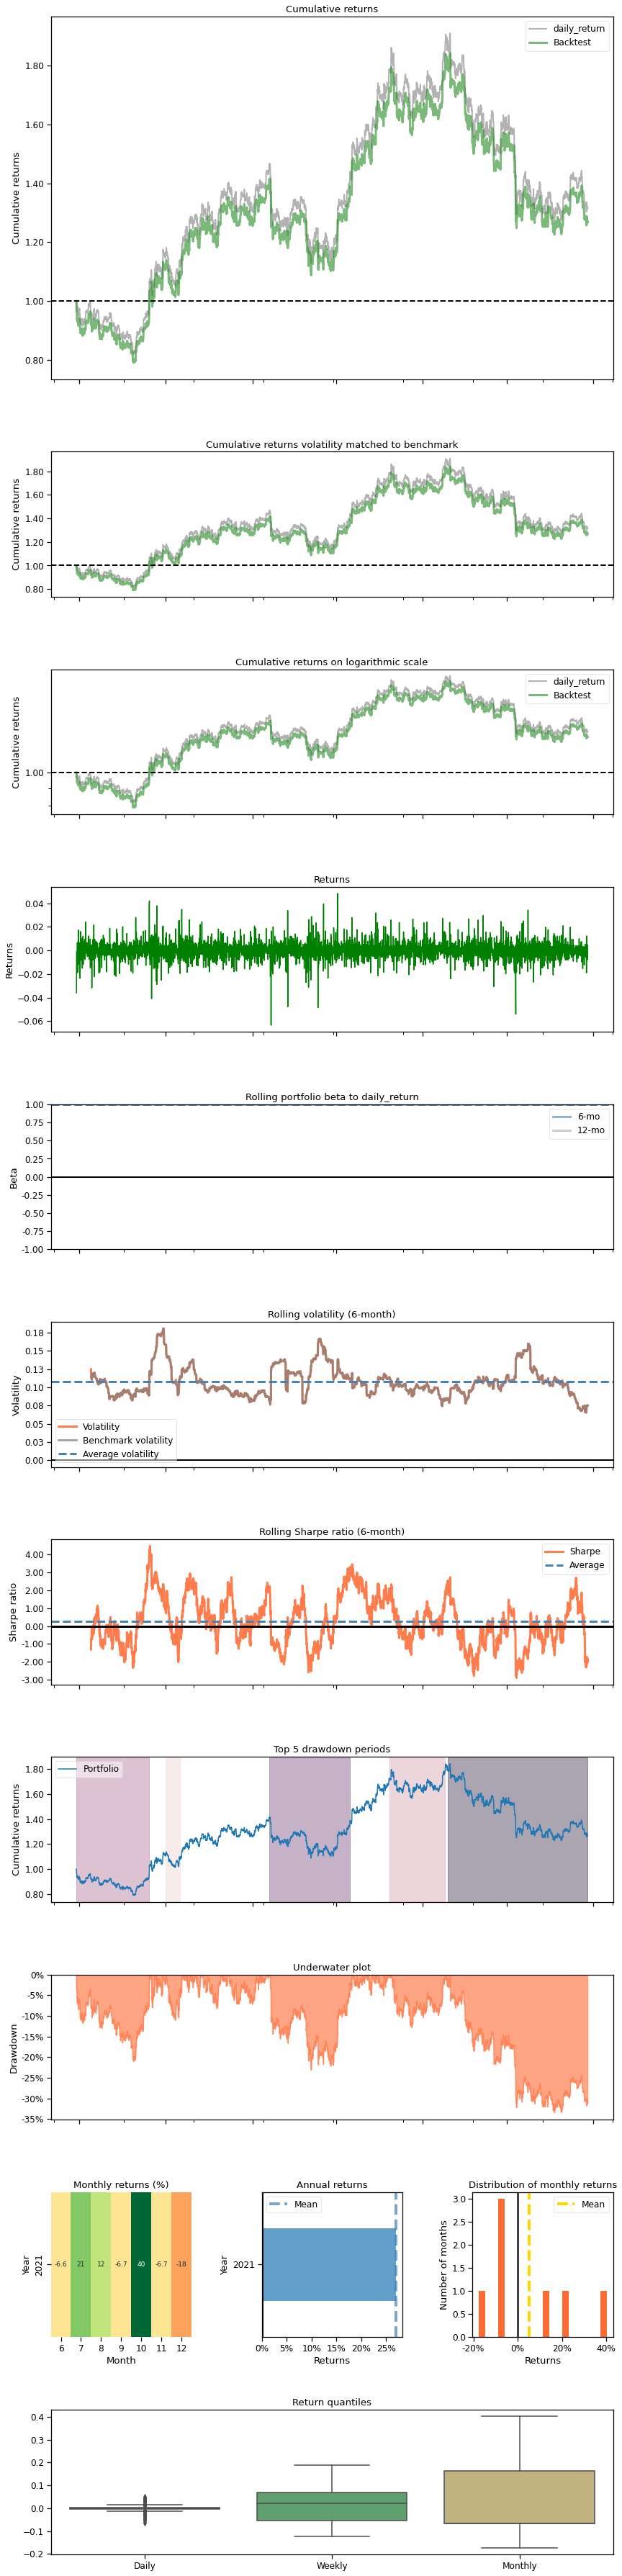

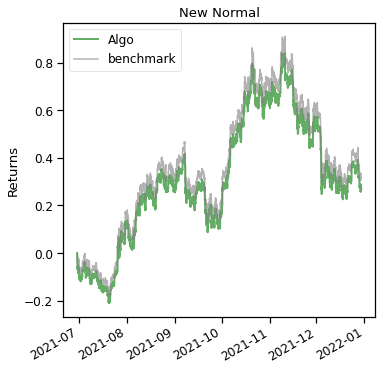

In [74]:
print("==============Compare to Crypto Index===========")
%matplotlib inline
backtest_plot_mod(df_account_value, baseline_df)

In [ ]:
# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value, 
#              baseline_ticker = '^DJI', 
#              baseline_start = df_account_value.loc[0,'date'],
#              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])